In [8]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5400769539158621599
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10730904380335944602
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15946556532259080702
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10512528180
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12468777960215907978
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [13]:
df = pd.read_csv('paths_and_labels.csv')

In [14]:
df.head()

,img_path,class
0,mdb003.pgm.png,dense
1,mdb004.pgm.png,dense
2,mdb033.pgm.png,dense
3,mdb034.pgm.png,dense
4,mdb035.pgm.png,dense


In [15]:
df.img_path[0]

'mdb003.pgm.png'

## First, let's look at what our plan images look like:

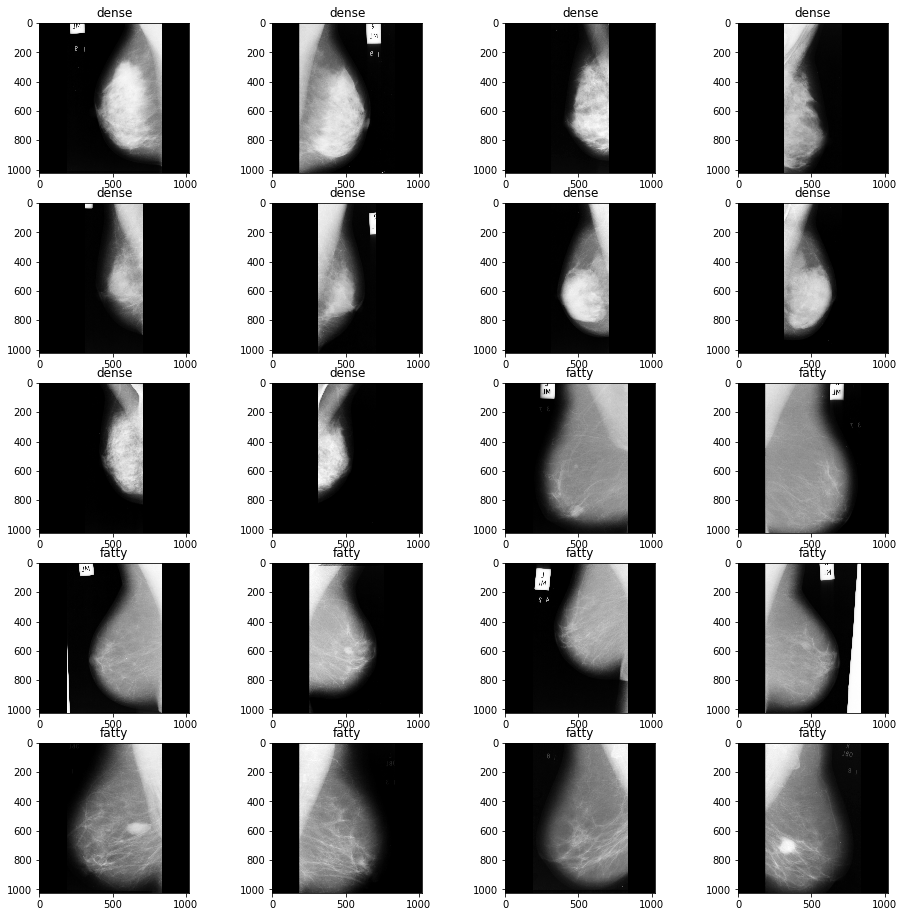

In [16]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df.img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df.iloc[ind]['class'])
    ind=ind+1

In [17]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

## Below, you will alter the values of the parameters that you pass to ImageDataGenerator. The following cell, you'll display what your augmented images look like. 

#### Play around with different values for the parameters, running the visualization cell below each time to see how these parameters change the appearance of your augmented data. Make some conclusions about what sorts of values might or might not be appropriate for medical imaging based on what you might see in the real world. You can look at the ImageDataGenerator documentation in Keras to add other parameters as well. 

* horizontal_flip and vertical_flip should be set to True/False
* height_shift_range and width_shift_range should be between 0 and 1
* rotation_range can be between 0 and 180
* shear_range can be between 0 and 1
* zoom_range can be between 0 and 1

In [18]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

Found 20 validated image filenames belonging to 2 classes.


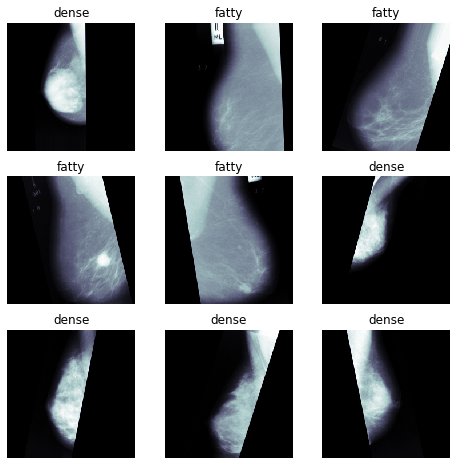

In [19]:
## Look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared
## With how the raw data look prior to augmentation
t_x, t_y = next(gen)
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('fatty')
    else:
        c_ax.set_title('dense')
    c_ax.axis('off')

These look reasonable from a medical imaging point of view. Let's see what happens when we choose different parameters (I'm just copying the above two cells and running them again below with other parameters.) 

In [20]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = True, ## now i'm adding vertical flip
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=45, ## I'm also increasing the rotation_range
                              shear_range = 0.1,
                              zoom_range=0.1)

gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

Found 20 validated image filenames belonging to 2 classes.


In [ ]:
## Look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared
## With how the raw data look prior to augmentation
t_x, t_y = next(gen)
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('fatty')
    else:
        c_ax.set_title('dense')
    c_ax.axis('off')

These do *not* look reasonable. There are upside-down images because I added vertical flip, which we'd never see in a clinical setting. So, we _don't_ want to use this type of augmentation with medical images.

In [ ]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.5) ## Here I'm adding a lot more zoom 

gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

In [ ]:
## Look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared
## With how the raw data look prior to augmentation
t_x, t_y = next(gen)
fig, m_axs = plt.subplots(3, 3, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('fatty')
    else:
        c_ax.set_title('dense')
    c_ax.axis('off')

These don't look too bad, although it's possible that too much zoom was added. There's no "right" answer for this one, just gaining an understanding of how these parameters change your augmented images. 